In [4]:
from google.colab import files
files.upload()

!unzip /content/dataset_ts.zip -d /content/data

Saving dataset_ts.zip to dataset_ts.zip
Archive:  /content/dataset_ts.zip
   creating: /content/data/test/
   creating: /content/data/train/
   creating: /content/data/val/
   creating: /content/data/train/features/
   creating: /content/data/train/target/
  inflating: /content/data/train/target/0880.npy  
  inflating: /content/data/train/target/0323.npy  
  inflating: /content/data/train/target/0819.npy  
  inflating: /content/data/train/target/1285.npy  
  inflating: /content/data/train/target/1074.npy  
  inflating: /content/data/train/target/0362.npy  
  inflating: /content/data/train/target/1397.npy  
  inflating: /content/data/train/target/0038.npy  
  inflating: /content/data/train/target/1319.npy  
  inflating: /content/data/train/target/1517.npy  
  inflating: /content/data/train/target/0780.npy  
  inflating: /content/data/train/target/1028.npy  
  inflating: /content/data/train/target/0231.npy  
  inflating: /content/data/train/target/1648.npy  
  inflating: /content/data/tr

## Conv2dLSTM

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ------------------- Dataset -------------------
class FolderTimeSeriesDataset(Dataset):
    """
    PyTorch Dataset load từng file .npy từ folder:
    dataset_ts/train/val/test
        features/0000.npy
        target/0000.npy
    """
    def __init__(self, root_dir, time_in=30, time_out=1):
        self.feature_dir = os.path.join(root_dir, "features")
        self.target_dir  = self.feature_dir

        self.feature_files = sorted(os.listdir(self.feature_dir))
        self.target_files  = sorted(os.listdir(self.target_dir))
        assert len(self.feature_files) == len(self.target_files), "features != target"

        self.time_in = time_in
        self.time_out = time_out

        # Tạo danh sách index cho sliding window
        self.sample_indices = []
        total_timesteps = len(self.feature_files)
        for i in range(total_timesteps - time_in - time_out + 1):
            self.sample_indices.append(i)

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        start_idx = self.sample_indices[idx]

        # Load input sequence
        X_list = []
        for i in range(start_idx, start_idx + self.time_in):
            feat = np.load(os.path.join(self.feature_dir, self.feature_files[i]))  # [H,W,C]
            feat = np.transpose(feat, (2,0,1))  # [C,H,W]
            X_list.append(feat)
        X = np.stack(X_list, axis=0)  # [time_in, C, H, W]

        # Load output sequence
        Y_list = []
        for i in range(start_idx + self.time_in, start_idx + self.time_in + self.time_out):
            targ = np.load(os.path.join(self.target_dir, self.target_files[i]))  # [H,W,C] (C=1)
            targ = np.transpose(targ, (2,0,1))  # [C,H,W]
            Y_list.append(targ)
        Y = np.stack(Y_list, axis=0)  # [time_out, C, H, W]

        return torch.FloatTensor(X), torch.FloatTensor(Y)

# ------------------- ConvLSTM Cell -------------------
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(
            input_dim + hidden_dim,
            4 * hidden_dim,
            kernel_size,
            padding=self.padding,
            bias=bias
        )

    def forward(self, x, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([x, h_cur], dim=1)
        conv_out = self.conv(combined)
        i, f, o, g = torch.split(conv_out, self.hidden_dim, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size, device):
        H, W = image_size
        return (torch.zeros(batch_size, self.hidden_dim, H, W, device=device),
                torch.zeros(batch_size, self.hidden_dim, H, W, device=device))

# ------------------- ConvLSTM -------------------
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=True, bias=True, return_all_layers=False):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim if isinstance(hidden_dim, list) else [hidden_dim]*num_layers
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.return_all_layers = return_all_layers

        self.cell_list = nn.ModuleList()
        for i in range(num_layers):
            cur_in = input_dim if i==0 else self.hidden_dim[i-1]
            self.cell_list.append(ConvLSTMCell(cur_in, self.hidden_dim[i], kernel_size, bias=bias))

    def forward(self, x, hidden_state=None):
        if not self.batch_first:
            x = x.permute(1,0,2,3,4)
        B, T, C, H, W = x.size()
        if hidden_state is None:
            device = x.device
            hidden_state = [cell.init_hidden(B, (H,W), device) for cell in self.cell_list]

        layer_output_list = []
        last_state_list = []

        cur_input = x
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(T):
                h, c = self.cell_list[layer_idx](cur_input[:,t], [h,c])
                output_inner.append(h)
            layer_out = torch.stack(output_inner, dim=1)
            cur_input = layer_out
            layer_output_list.append(layer_out)
            last_state_list.append([h,c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]
        return layer_output_list, last_state_list

# ------------------- Forecaster -------------------
class ConvLSTMForecaster(nn.Module):
    def __init__(self, input_channels, hidden_dims=[64,32,16], kernel_size=3, dropout_rate=0.2):
        super().__init__()
        self.convlstm = ConvLSTM(input_channels, hidden_dims, kernel_size, len(hidden_dims),
                                 batch_first=True)
        self.batch_norm = nn.BatchNorm2d(hidden_dims[-1])
        self.dropout = nn.Dropout2d(dropout_rate)
        self.output_conv = nn.Conv2d(hidden_dims[-1], input_channels, kernel_size=3, padding=1)

    def forward(self, x):
        layer_out, last_state = self.convlstm(x)
        h_last = last_state[0][0]  # last hidden of last layer
        h_last = self.batch_norm(h_last)
        h_last = self.dropout(h_last)
        out = self.output_conv(h_last)
        out = out.unsqueeze(1)  # [B,1,C,H,W]
        return out

# ------------------- Training -------------------
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001,
                device='cuda', checkpoint_path='best_model.pth'):
    """
    Huấn luyện mô hình PyTorch với tqdm progress bars
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-6
    )

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15

    history = {'train_loss': [], 'train_mae': [], 'val_loss': [], 'val_mae': []}

    print(f"\n{'='*60}")
    print(f"🚀 Training ConvLSTM Model on {device}")
    print(f"{'='*60}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Max epochs: {epochs}")
    print(f"{'='*60}\n")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_mae = 0.0

        # Progress bar cho training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]',
                         leave=False, ncols=100)

        for batch_idx, (inputs, targets) in enumerate(train_pbar):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.mean(torch.abs(outputs - targets)).item()

            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{loss.item():.6f}',
                'mae': f'{torch.mean(torch.abs(outputs - targets)).item():.6f}'
            })

        train_loss /= len(train_loader)
        train_mae /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        # Progress bar cho validation
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]',
                       leave=False, ncols=100)

        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                batch_loss = criterion(outputs, targets).item()
                batch_mae = torch.mean(torch.abs(outputs - targets)).item()

                val_loss += batch_loss
                val_mae += batch_mae

                # Update progress bar
                val_pbar.set_postfix({
                    'loss': f'{batch_loss:.6f}',
                    'mae': f'{batch_mae:.6f}'
                })

        val_loss /= len(val_loader)
        val_mae /= len(val_loader)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_mae'].append(train_mae)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.6f}, Train MAE: {train_mae:.6f}, "
              f"Val Loss: {val_loss:.6f}, Val MAE: {val_mae:.6f}")

        # Early stopping and checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, checkpoint_path)
            print(f"  ✓ Model saved (val_loss: {val_loss:.6f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping triggered after {epoch+1} epochs")
                break

    print(f"\n{'='*60}")
    print(f"✅ Training completed!")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"{'='*60}\n")

    return history

# ------------------- Autoregressive Forecast -------------------
def autoregressive_forecast(model, initial_seq, n_days=7, device='cuda'):
    """
    initial_seq: [1,time_in,C,H,W]
    """
    model.eval()
    current_seq = initial_seq.to(device)
    preds = []

    with torch.no_grad():
        for _ in range(n_days):
            out = model(current_seq)  # [1,1,C,H,W]
            preds.append(out[0,0].cpu().numpy())
            current_seq = torch.cat([current_seq[:,1:], out], dim=1)
    return np.array(preds)  # [n_days,C,H,W]

# ------------------- Visualization -------------------
def visualize_training(history):
    plt.figure(figsize=(10,4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_results(history, true_data, predictions, feature_names=None, save_path=None):
    """
    Visualize training results và predictions
    true_data, predictions: (n_days, C, H, W) format
    """
    n_days, C, H, W = predictions.shape

    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(C)]

    # 1. Training curves
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('MSE Loss', fontsize=12)
    axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['train_mae'], label='Train MAE', linewidth=2)
    axes[1].plot(history['val_mae'], label='Val MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Training & Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_training.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 2. Spatial predictions
    n_features_show = min(3, C)
    n_days_show = min(3, n_days)

    fig, axes = plt.subplots(n_days_show, n_features_show * 2,
                            figsize=(4*n_features_show*2, 4*n_days_show))

    if n_days_show == 1:
        axes = axes.reshape(1, -1)

    for day_idx in range(n_days_show):
        for feat_idx in range(n_features_show):
            # True
            ax_true = axes[day_idx, feat_idx*2]
            im1 = ax_true.imshow(true_data[day_idx, feat_idx, :, :],
                                cmap='viridis', vmin=0, vmax=1)
            ax_true.set_title(f'Day {day_idx+1} - {feature_names[feat_idx]} (True)',
                            fontweight='bold')
            ax_true.axis('off')
            plt.colorbar(im1, ax=ax_true, fraction=0.046)

            # Predicted
            ax_pred = axes[day_idx, feat_idx*2 + 1]
            im2 = ax_pred.imshow(predictions[day_idx, feat_idx, :, :],
                                cmap='viridis', vmin=0, vmax=1)
            ax_pred.set_title(f'Day {day_idx+1} - {feature_names[feat_idx]} (Pred)',
                            fontweight='bold')
            ax_pred.axis('off')
            plt.colorbar(im2, ax=ax_pred, fraction=0.046)

    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

In [10]:
import torch
from torch.utils.data import DataLoader
import os

time_in = 30   # số ngày input
time_out = 1   # số ngày output

train_dataset = FolderTimeSeriesDataset("data/train", time_in=time_in, time_out=time_out)
val_dataset   = FolderTimeSeriesDataset("data/val", time_in=time_in, time_out=time_out)
test_dataset  = FolderTimeSeriesDataset("data/test", time_in=time_in, time_out=time_out)

# Tạo DataLoader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")




input_channels = train_dataset[0][0].shape[1]  # số channel của features
hidden_dims = [64, 32, 16]                     # cấu hình hidden dims
kernel_size = 3
dropout_rate = 0.2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ConvLSTMForecaster(
    input_channels=input_channels,
    hidden_dims=hidden_dims,
    kernel_size=kernel_size,
    dropout_rate=dropout_rate
).to(device)

print(f"Model initialized on {device}")


# ----------------------------------------
# 3. Huấn luyện mô hình
# ----------------------------------------


epochs = 10
learning_rate = 0.001
checkpoint_path = "conv_lstm_best.pth"

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=learning_rate,
    device=device,
    checkpoint_path=checkpoint_path
)

Train batches: 113, Val batches: 10, Test batches: 10
Model initialized on cuda

🚀 Training ConvLSTM Model on cuda
Training batches: 113
Validation batches: 10
Max epochs: 10



Epoch 1/10 - Train Loss: 0.092206, Train MAE: 0.214282, Val Loss: 0.166031, Val MAE: 0.347240
  ✓ Model saved (val_loss: 0.166031)


Epoch 2/10 - Train Loss: 0.023982, Train MAE: 0.112212, Val Loss: 0.032046, Val MAE: 0.135312
  ✓ Model saved (val_loss: 0.032046)


Epoch 3/10 - Train Loss: 0.022527, Train MAE: 0.108448, Val Loss: 0.041422, Val MAE: 0.161171


Epoch 4/10 - Train Loss: 0.021318, Train MAE: 0.105040, Val Loss: 0.045388, Val MAE: 0.170660


Epoch 5/10 - Train Loss: 0.020226, Train MAE: 0.101743, Val Loss: 0.017779, Val MAE: 0.100644
  ✓ Model saved (val_loss: 0.017779)


Epoch 6/10 - Train Loss: 0.019896, Train MAE: 0.100955, Val Loss: 0.029087, Val MAE: 0.136161


Epoch 7/10 - Train Loss: 0.019679, Train MAE: 0.100144, Val Loss: 0.019826, Val MAE: 0.106995


Epoch 8/10 - Train Loss: 0.018926, Train MAE: 0.097880, Val Loss: 0.023421, Val MAE: 0.119025


Epoch 9/10 - Train Loss: 0.018485, Train MAE: 0.096758, Val Loss: 0.017157, Val MAE: 0.094724
  ✓ Model saved (val_loss: 0.017157)


Epoch 10/10 - Train Loss: 0.018031, Train MAE: 0.095233, Val Loss: 0.039203, Val MAE: 0.158908

✅ Training completed!
Best validation loss: 0.017157



Predictions shape: (7, 24, 35, 35)


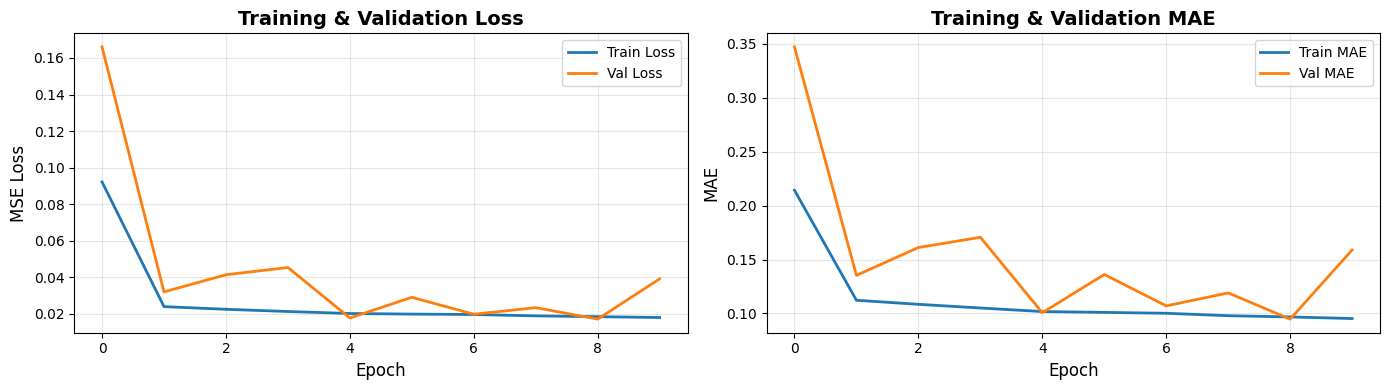

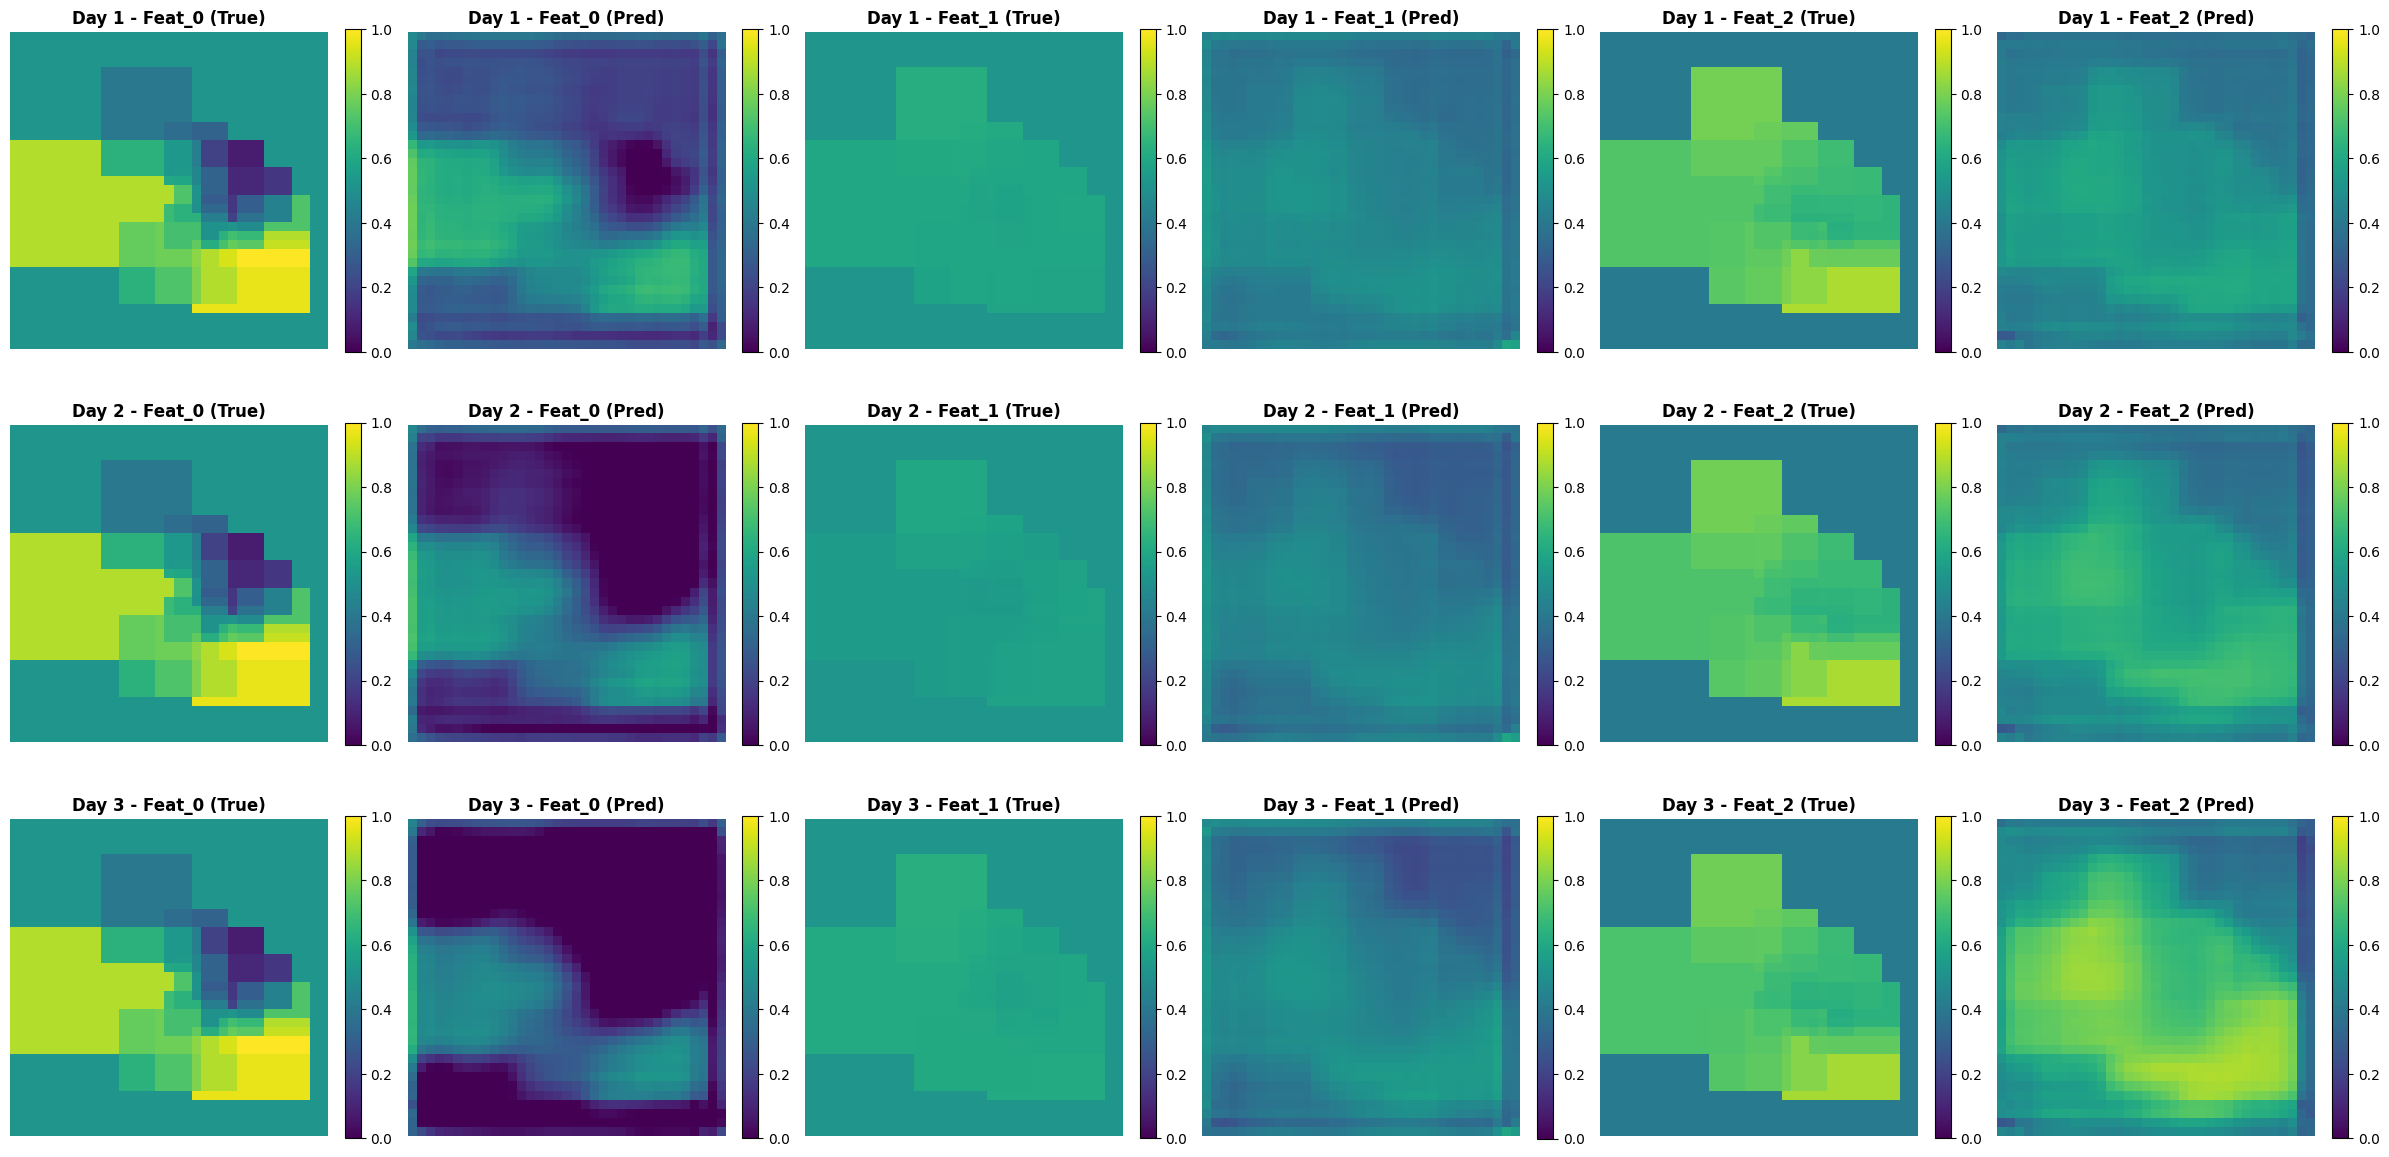

test MSE: 0.03740135915577412
test MAE: 0.15251817107200621


In [15]:
# Lấy 1 sequence đầu tiên trong test dataset
initial_seq, _ = test_dataset[0]  # initial_seq shape: (time_in, C, H, W)

# Thêm batch dimension: (1, time_in, C, H, W)
initial_seq = initial_seq.unsqueeze(0)

n_days_predict = 7

predictions = autoregressive_forecast(
    model=model,
    initial_seq=initial_seq,
    n_days=n_days_predict,
    device=device
)

print(f"Predictions shape: {predictions.shape}")  # (n_days, C, H, W)


# ----------------------------------------
# 5. Visualize kết quả
# ----------------------------------------


# Lấy ground truth 7 ngày tương ứng (chú ý test dataset đã sliding window)
true_data = torch.stack([test_dataset[i][1][0] for i in range(n_days_predict)]).numpy()  # (n_days, C, H, W)

visualize_results(
    history=history,
    true_data=true_data,
    predictions=predictions,
    feature_names=[f"Feat_{i}" for i in range(input_channels)],
    save_path=None
)
criterion = nn.MSELoss()

test_loss = 0.0
test_mae = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        batch_loss = criterion(outputs, targets).item()
        batch_mae = torch.mean(torch.abs(outputs - targets)).item()

        test_loss += batch_loss
        test_mae += batch_mae

test_loss /= len(val_loader)
test_mae /= len(val_loader)

print("test MSE:", test_loss)
print("test MAE:", test_mae)

## U-Net

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class TensorTimeSeriesDataset(Dataset):
    """
    Dataset PyTorch cho tensor 3D time-series lưu trên disk
    """
    def __init__(self, root_dir):
        """
        root_dir: đường dẫn tới folder 'train', 'val' hoặc 'test'
        """
        self.feature_dir = os.path.join(root_dir, "features")
        self.target_dir  = os.path.join(root_dir, "target")

        self.feature_files = sorted(os.listdir(self.feature_dir))
        self.target_files  = sorted(os.listdir(self.target_dir))

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        # Load feature và target
        feat_path = os.path.join(self.feature_dir, self.feature_files[idx])
        targ_path = os.path.join(self.target_dir, self.target_files[idx])

        feature = np.load(feat_path)  # [H, W, C]
        target  = np.load(targ_path)  # [H, W, 1]

        # Chuyển sang tensor và permute để Conv2D input: [C, H, W]
        feature = torch.from_numpy(feature).float().permute(2, 0, 1)  # [C,H,W]
        target  = torch.from_numpy(target).float().permute(2, 0, 1)   # [1,H,W]

        return feature, target

# ==================== MODEL ====================
class UNet(nn.Module):
    def __init__(self, in_channels=21, out_channels=21, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder_layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder_layers.append(self._conv_block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self._conv_block(features[-1], features[-1]*2)

        # Decoder
        self.upconv_layers = nn.ModuleList()
        self.decoder_layers = nn.ModuleList()
        for feature in reversed(features):
            self.upconv_layers.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder_layers.append(self._conv_block(feature*2, feature))

        # Output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for layer in self.encoder_layers:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.upconv_layers)):
            x = self.upconv_layers[idx](x)
            skip_connection = skip_connections[idx]

            # Handle size mismatch
            if x.shape != skip_connection.shape:
                x = self._crop_to_fit(x, skip_connection)

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_layers[idx](x)

        return self.final_conv(x)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _crop_to_fit(self, x, target):
        """
        Crop or pad x to match target's H and W
        """
        _, _, H, W = target.shape
        h_diff = H - x.size(2)
        w_diff = W - x.size(3)

        # Pad nếu x nhỏ hơn target
        x = nn.functional.pad(x, (0, max(0, w_diff), 0, max(0, h_diff)))

        # Crop nếu x lớn hơn target
        x = x[:, :, :H, :W]
        return x

# ==================== TRAINING FUNCTION ====================
def train_model_unet(model, train_loader, val_loader, epochs, lr, device, checkpoint_path):
    """
    Huấn luyện mô hình U-Net với tqdm progress bars
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-6
    )

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15

    history = {'train_loss': [], 'train_mae': [], 'val_loss': [], 'val_mae': []}

    print(f"\n{'='*60}")
    print(f"🚀 Training U-Net Model on {device}")
    print(f"{'='*60}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Max epochs: {epochs}")
    print(f"{'='*60}\n")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_mae = 0.0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]',
                         leave=False, ncols=100)

        for batch_idx, (inputs, targets) in enumerate(train_pbar):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.mean(torch.abs(outputs - targets)).item()

            train_pbar.set_postfix({
                'loss': f'{loss.item():.6f}',
                'mae': f'{torch.mean(torch.abs(outputs - targets)).item():.6f}'
            })

        train_loss /= len(train_loader)
        train_mae /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]',
                       leave=False, ncols=100)

        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                batch_loss = criterion(outputs, targets).item()
                batch_mae = torch.mean(torch.abs(outputs - targets)).item()

                val_loss += batch_loss
                val_mae += batch_mae

                val_pbar.set_postfix({
                    'loss': f'{batch_loss:.6f}',
                    'mae': f'{batch_mae:.6f}'
                })

        val_loss /= len(val_loader)
        val_mae /= len(val_loader)

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_mae'].append(train_mae)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.6f}, Train MAE: {train_mae:.6f}, "
              f"Val Loss: {val_loss:.6f}, Val MAE: {val_mae:.6f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'history': history
            }, checkpoint_path)
            print(f"  ✓ Model saved (val_loss: {val_loss:.6f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping triggered after {epoch+1} epochs")
                break

    print(f"\n{'='*60}")
    print(f"✅ Training completed!")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"{'='*60}\n")

    return history


# ==================== EVALUATION ====================
def evaluate_model(model, test_loader, device, scaler_target=None):
    """
    Đánh giá mô hình trên tập test.
    Nếu có scaler_target thì tự động inverse_transform để so sánh trên giá trị thật (mm/ngày).
    """
    model.eval()
    criterion = nn.MSELoss()

    total_loss = 0.0
    total_mae = 0.0
    all_predictions = []
    all_targets = []

    print("\n🔍 Evaluating model on test set...")

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing', ncols=100):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            mae = torch.mean(torch.abs(outputs - targets))

            total_loss += loss.item()
            total_mae += mae.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    avg_mae = total_mae / len(test_loader)

    preds = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    print(f"\n📊 Test Results (scaled):")
    print(f"  MSE Loss: {avg_loss:.6f}")
    print(f"  MAE: {avg_mae:.6f}")

    # ==============================
    # 🔁 Inverse transform (nếu có scaler)
    # ==============================
    if scaler_target is not None:
        # reshape về (N, H*W)
        N, C, H, W = preds.shape
        preds_2d = preds.reshape(-1, 1)
        targets_2d = targets.reshape(-1, 1)

        preds_inv = scaler_target.inverse_transform(preds_2d).reshape(N, C, H, W)
        targets_inv = scaler_target.inverse_transform(targets_2d).reshape(N, C, H, W)

        mse_real = np.mean((preds_inv - targets_inv) ** 2)
        mae_real = np.mean(np.abs(preds_inv - targets_inv))

        print(f"\n🌧️ Test Results (after inverse transform - mm/day):")
        print(f"  MSE: {mse_real:.6f}")
        print(f"  MAE: {mae_real:.6f}")

        return {
            'loss_scaled': avg_loss,
            'mae_scaled': avg_mae,
            'loss_real': mse_real,
            'mae_real': mae_real,
            'preds_scaled': preds,
            'targets_scaled': targets,
            'preds_real': preds_inv,
            'targets_real': targets_inv
        }

    return {
        'loss_scaled': avg_loss,
        'mae_scaled': avg_mae,
        'preds_scaled': preds,
        'targets_scaled': targets
    }



# ==================== VISUALIZATION ====================
def plot_training_history(history, save_path='training_history.png'):
    """
    Vẽ biểu đồ quá trình training
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('MSE Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # MAE plot
    axes[1].plot(history['train_mae'], label='Train MAE', linewidth=2)
    axes[1].plot(history['val_mae'], label='Val MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📈 Training history saved to {save_path}")
    plt.show()

def evaluate_model(model, test_loader, device, minmax=None, robust=None):
    """
    Đánh giá mô hình trên tập test.
    Nếu có scaler_target thì tự động inverse_transform để so sánh trên giá trị thật (mm/ngày).
    """
    model.eval()
    criterion = nn.MSELoss()

    total_loss = 0.0
    total_mae = 0.0
    all_predictions = []
    all_targets = []

    print("\n🔍 Evaluating model on test set...")

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing', ncols=100):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            mae = torch.mean(torch.abs(outputs - targets))

            total_loss += loss.item()
            total_mae += mae.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    avg_mae = total_mae / len(test_loader)

    preds = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    print(f"\n📊 Test Results (scaled):")
    print(f"  MSE Loss: {avg_loss:.6f}")
    print(f"  MAE: {avg_mae:.6f}")

    # ==============================
    # 🔁 Inverse transform (nếu có scaler)
    # ==============================
    if minmax is not None and robust is not None:
        # reshape về (N, H*W)
        N, C, H, W = preds.shape
        preds_2d = preds.reshape(-1, 1)
        targets_2d = targets.reshape(-1, 1)

        preds_inv = robust.inverse_transform(minmax.inverse_transform(preds_2d)).reshape(N, C, H, W)
        targets_inv = robust.inverse_transform(minmax.inverse_transform(targets_2d)).reshape(N, C, H, W)

        mse_real = np.mean((preds_inv - targets_inv) ** 2)
        mae_real = np.mean(np.abs(preds_inv - targets_inv))

        print(f"\n🌧️ Test Results (after inverse transform - mm/day):")
        print(f"  MSE: {mse_real:.6f}")
        print(f"  MAE: {mae_real:.6f}")

        return {
            'loss_scaled': avg_loss,
            'mae_scaled': avg_mae,
            'loss_real': mse_real,
            'mae_real': mae_real,
            'preds_scaled': preds,
            'targets_scaled': targets,
            'preds_real': preds_inv,
            'targets_real': targets_inv
        }

    return {
        'loss_scaled': avg_loss,
        'mae_scaled': avg_mae,
        'preds_scaled': preds,
        'targets_scaled': targets
    }

def visualize_predictions_last(predictions, targets, num_samples=3, channel=0, save_path='predictions.png'):
    """
    Hiển thị kết quả dự đoán
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        pred = predictions[i, channel]
        target = targets[i, channel]
        diff = np.abs(pred - target)

        # Target
        im1 = axes[i, 0].imshow(target, cmap='viridis')
        axes[i, 0].set_title(f'Sample {i+1}: Ground Truth', fontweight='bold')
        axes[i, 0].axis('off')
        plt.colorbar(im1, ax=axes[i, 0], fraction=0.046)

        # Prediction
        im2 = axes[i, 1].imshow(pred, cmap='viridis')
        axes[i, 1].set_title(f'Sample {i+1}: Prediction', fontweight='bold')
        axes[i, 1].axis('off')
        plt.colorbar(im2, ax=axes[i, 1], fraction=0.046)

        # Difference
        im3 = axes[i, 2].imshow(diff, cmap='Reds')
        axes[i, 2].set_title(f'Sample {i+1}: Absolute Error', fontweight='bold')
        axes[i, 2].axis('off')
        plt.colorbar(im3, ax=axes[i, 2], fraction=0.046)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"🖼️  Predictions saved to {save_path}")
    plt.show()

In [27]:
train_dataset_last = TensorTimeSeriesDataset("data/train")
val_dataset_last   = TensorTimeSeriesDataset("data/val")
test_dataset_last = TensorTimeSeriesDataset("data/test")

train_loader_last = DataLoader(train_dataset_last, batch_size=16, shuffle=False)
val_loader_last   = DataLoader(val_dataset_last, batch_size=16, shuffle=False)
test_loader_last  = DataLoader(test_dataset_last, batch_size=16, shuffle=False)

in_channels = train_dataset_last[0][0].shape[0]
out_channels = train_dataset_last[1][1].shape[0]
model = UNet(in_channels=in_channels, out_channels=out_channels,
            features=[32, 64, 128, 256]).to(device)

print(f"\n🏗️  Model architecture:")
print(f"Input channels: {in_channels}")
print(f"Output channels: {out_channels}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# ===== TRAINING =====
checkpoint_path = 'best_unet_model.pth'
history = train_model_unet(
  model=model,
  train_loader=train_loader_last,
  val_loader=val_loader_last,
  epochs=20,
  lr=1e-3,
  device=device,
  checkpoint_path=checkpoint_path
)


🏗️  Model architecture:
Input channels: 24
Output channels: 1
Total parameters: 7,772,033

🚀 Training U-Net Model on cuda
Training batches: 115
Validation batches: 12
Max epochs: 20



Epoch 1/20 - Train Loss: 0.006883, Train MAE: 0.055766, Val Loss: 0.003473, Val MAE: 0.037678, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.003473)


Epoch 2/20 - Train Loss: 0.002606, Train MAE: 0.034070, Val Loss: 0.001447, Val MAE: 0.023373, LR: 1.00e-03
  ✓ Model saved (val_loss: 0.001447)


Epoch 3/20 - Train Loss: 0.002543, Train MAE: 0.031070, Val Loss: 0.016514, Val MAE: 0.066655, LR: 1.00e-03


Epoch 4/20 - Train Loss: 0.002164, Train MAE: 0.028542, Val Loss: 0.043974, Val MAE: 0.114826, LR: 1.00e-03


Epoch 5/20 - Train Loss: 0.001945, Train MAE: 0.028148, Val Loss: 0.012488, Val MAE: 0.066934, LR: 1.00e-03


Epoch 6/20 - Train Loss: 0.001685, Train MAE: 0.025122, Val Loss: 0.006834, Val MAE: 0.057188, LR: 1.00e-03


Epoch 7/20 - Train Loss: 0.001590, Train MAE: 0.024880, Val Loss: 0.008164, Val MAE: 0.058952, LR: 1.00e-03


Epoch 8/20 - Train Loss: 0.001436, Train MAE: 0.022782, Val Loss: 0.004584, Val MAE: 0.047154, LR: 1.00e-03


Epoch 9/20 - Train Loss: 0.001319, Train MAE: 0.021071, Val Loss: 0.009380, Val MAE: 0.059777, LR: 1.00e-03


Epoch 10/20 - Train Loss: 0.001324, Train MAE: 0.021490, Val Loss: 0.003099, Val MAE: 0.043421, LR: 5.00e-04


Epoch 11/20 - Train Loss: 0.001189, Train MAE: 0.019894, Val Loss: 0.000880, Val MAE: 0.017890, LR: 5.00e-04
  ✓ Model saved (val_loss: 0.000880)


Epoch 12/20 - Train Loss: 0.001097, Train MAE: 0.018134, Val Loss: 0.000657, Val MAE: 0.014810, LR: 5.00e-04
  ✓ Model saved (val_loss: 0.000657)


Epoch 13/20 - Train Loss: 0.001067, Train MAE: 0.017640, Val Loss: 0.000723, Val MAE: 0.016136, LR: 5.00e-04


Epoch 14/20 - Train Loss: 0.001044, Train MAE: 0.017433, Val Loss: 0.000668, Val MAE: 0.015130, LR: 5.00e-04


Epoch 15/20 - Train Loss: 0.001026, Train MAE: 0.017236, Val Loss: 0.000660, Val MAE: 0.015178, LR: 5.00e-04


Epoch 16/20 - Train Loss: 0.001016, Train MAE: 0.017291, Val Loss: 0.000659, Val MAE: 0.015346, LR: 5.00e-04


Epoch 17/20 - Train Loss: 0.001006, Train MAE: 0.017391, Val Loss: 0.000661, Val MAE: 0.015572, LR: 5.00e-04


Epoch 18/20 - Train Loss: 0.001005, Train MAE: 0.017554, Val Loss: 0.000954, Val MAE: 0.019854, LR: 5.00e-04


Epoch 19/20 - Train Loss: 0.001038, Train MAE: 0.017903, Val Loss: 0.001188, Val MAE: 0.021106, LR: 5.00e-04


Epoch 20/20 - Train Loss: 0.001070, Train MAE: 0.018196, Val Loss: 0.000690, Val MAE: 0.017138, LR: 2.50e-04

✅ Training completed!
Best validation loss: 0.000657




📂 Loading best model...

🔍 Evaluating model on test set...


Testing: 100%|██████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.36it/s]



📊 Test Results (scaled):
  MSE Loss: 0.002364
  MAE: 0.024467

🌧️ Test Results (after inverse transform - mm/day):
  MSE: 20.555664
  MAE: 2.295803
📈 Training history saved to training_history.png


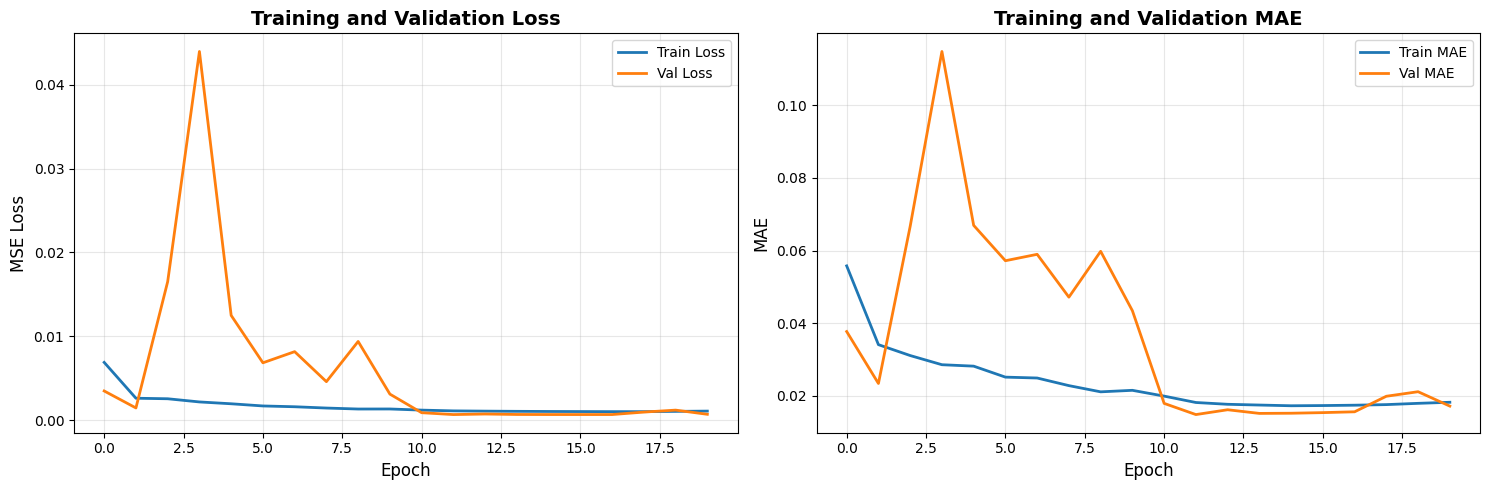

🖼️  Predictions saved to predictions.png


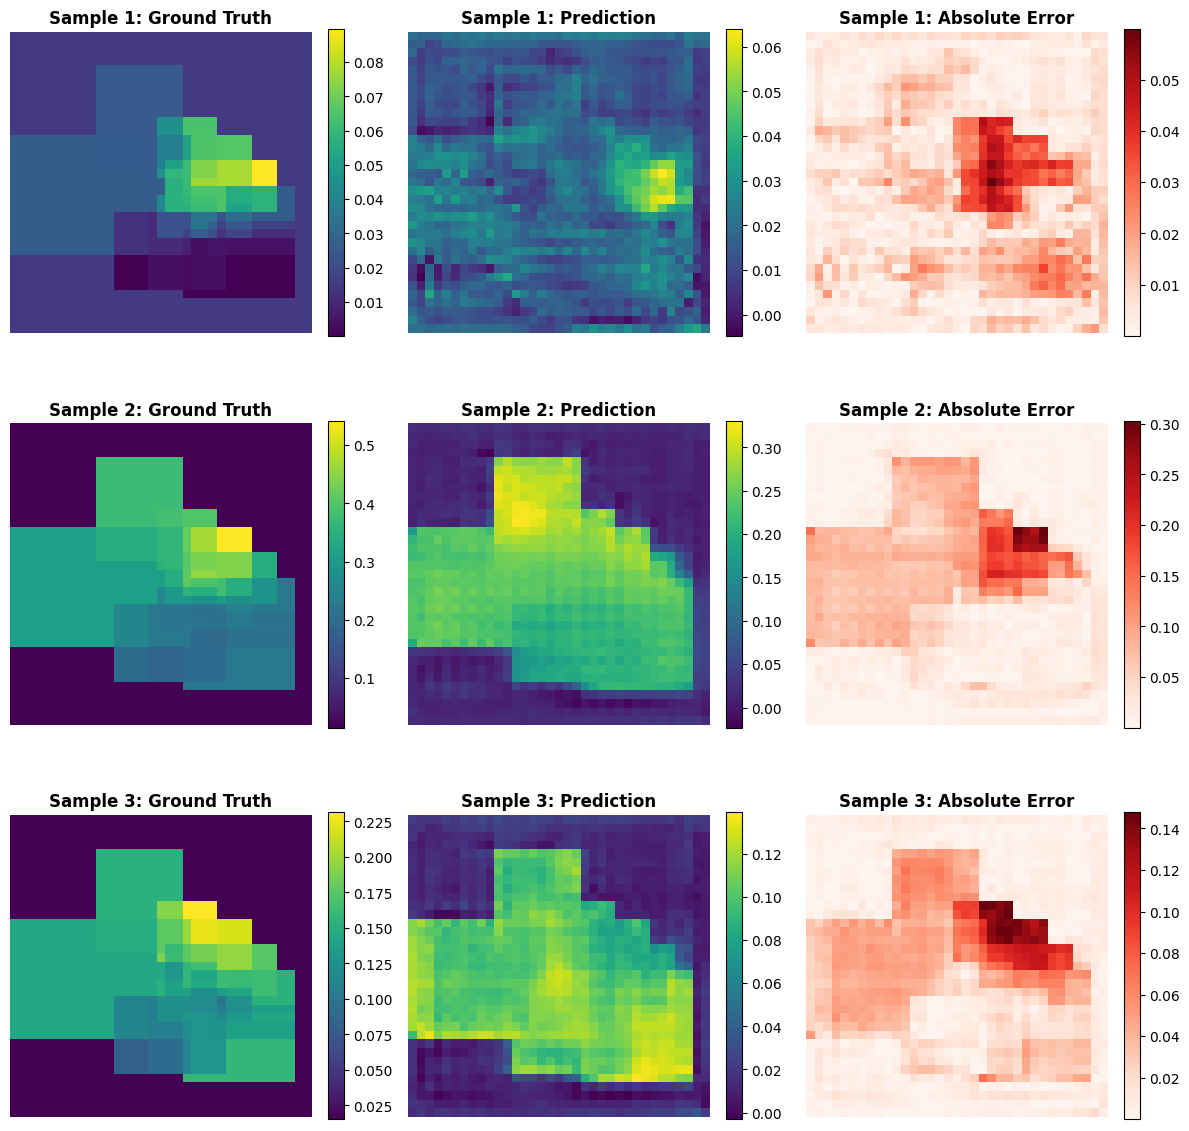


✨ All done!


In [34]:
import joblib
# ===== LOAD BEST MODEL =====
print("\n📂 Loading best model...")
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

# ===== EVALUATION =====
minmax = joblib.load('/content/data/minmax_scaler_target_train.pkl')
robust = joblib.load('/content/data/robust_scaler_target_train.pkl')
test_results = evaluate_model(model, test_loader_last, device, minmax, robust)

# ===== VISUALIZATION =====
plot_training_history(history)
visualize_predictions_last(test_results['preds_scaled'], test_results['targets_scaled'], num_samples=3)

print("\n✨ All done!")

## Predict

⏳ Số ngày cần dự đoán từ 31/12/2024: 2 ngày


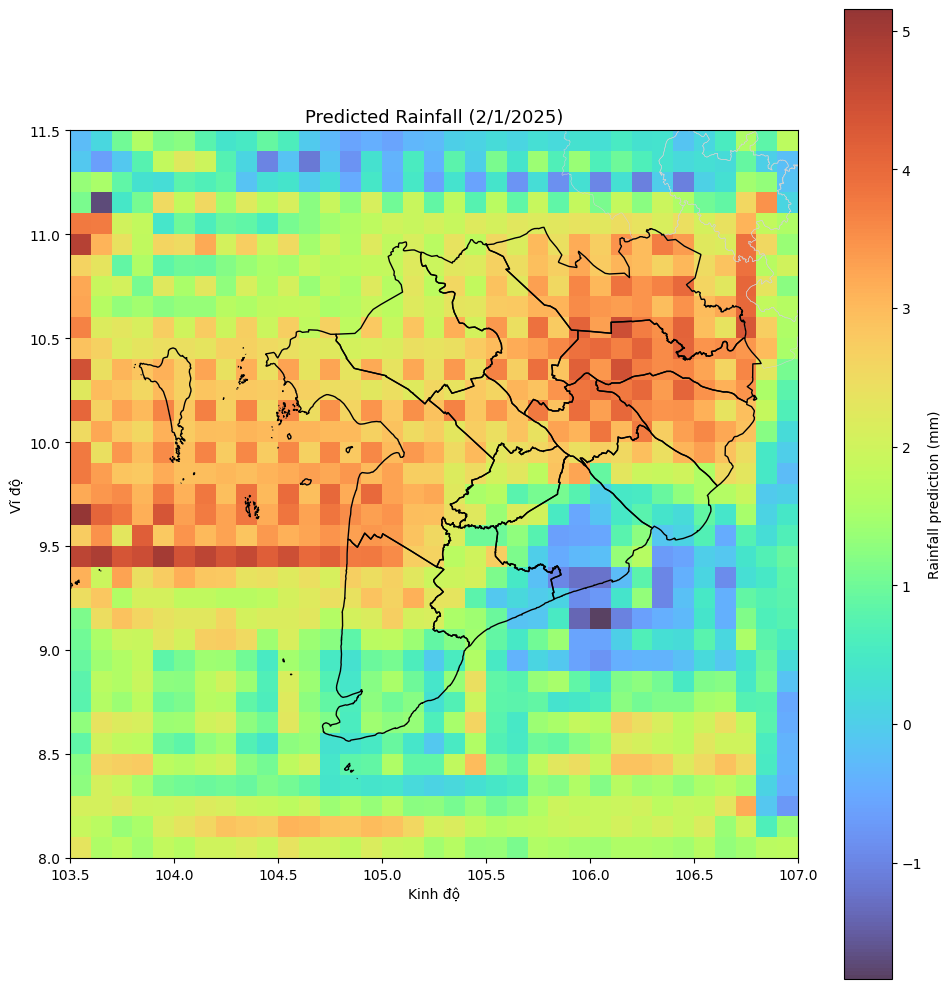

In [100]:
# ================================================================
# 📦 Rainfall Prediction Pipeline (ConvLSTM + UNet)
# Author: Khoa Anh
# ================================================================
from datetime import datetime
import numpy as np
import torch
import matplotlib.pyplot as plt
import geopandas as gpd
import joblib


# ================================================================
# 🗺️ Visualization
# ================================================================
def plot_map(rain_map, title, vn_adm1, dbscl,
             min_lon=103.5, max_lon=107, min_lat=8, max_lat=11.5):
    """
    Hiển thị bản đồ dự đoán lượng mưa trên vùng ĐBSCL.
    """
    extent = [min_lon, max_lon, min_lat, max_lat]
    fig, ax = plt.subplots(figsize=(10, 10))

    # Ranh giới hành chính
    vn_adm1.boundary.plot(ax=ax, color='lightgrey', linewidth=0.4)
    dbscl.boundary.plot(ax=ax, color='black', linewidth=1)

    # Overlay ma trận dự đoán
    im = ax.imshow(rain_map, extent=extent, origin='lower',
                   cmap='turbo', alpha=0.8)

    # Tùy chỉnh hiển thị
    plt.colorbar(im, ax=ax, label="Rainfall prediction (mm)")
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Kinh độ")
    ax.set_ylabel("Vĩ độ")
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    plt.tight_layout()
    plt.show()


# ================================================================
# 🔁 Forecasting Functions
# ================================================================
def autoregressive_forecast_last(model, initial_seq, n_days=7, device='cuda'):
    """
    Dự đoán đặc trưng (feature maps) cho n_days tiếp theo
    bằng phương pháp autoregressive.
    """
    model.eval()
    current_seq = initial_seq.to(device)
    preds = []

    with torch.no_grad():
        for _ in range(n_days):
            out = model(current_seq)  # [1,1,C,H,W]
            preds.append(out[0, 0].cpu().numpy())
            current_seq = torch.cat([current_seq[:, 1:], out], dim=1)

    return np.array(preds)[-1]  # lấy ngày cuối cùng


def predict_rainfall(model, data, minmax, robust, device='cuda'):
    """
    Dự đoán lượng mưa (mm/ngày) từ feature maps đã được dự đoán.
    Tự động inverse scaling bằng MinMax + Robust.
    """
    model.eval()
    with torch.no_grad():
        preds = model(data)
        N, C, H, W = preds.shape

        preds_np = preds.detach().cpu().numpy().reshape(-1, 1)
        preds_inv = robust.inverse_transform(
            minmax.inverse_transform(preds_np)
        ).reshape(N, C, H, W)

    return preds_inv[0, 0]  # [H, W]


# ================================================================
# 🚀 Main Pipeline
# ================================================================
def main_predict(day, month, year):
    # ----- Thông tin thời gian -----
    start_date = datetime(2024, 12, 31)
    end_date = datetime(year, month, day)
    n_days = (end_date - start_date).days
    print(f"⏳ Số ngày cần dự đoán từ 31/12/2024: {n_days} ngày")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # ----- Load mô hình UNet -----
    in_channels = train_dataset_last[0][0].shape[0]
    out_channels = train_dataset_last[1][1].shape[0]
    model_unet = UNet(in_channels=in_channels, out_channels=out_channels,
                      features=[32, 64, 128, 256]).to(device)

    checkpoint = torch.load('/content/best_unet_model.pth', map_location=device)
    model_unet.load_state_dict(checkpoint['model_state_dict'])

    # ----- Load mô hình ConvLSTM -----
    input_channels = train_dataset[0][0].shape[1]
    conv2d_lstm_model = ConvLSTMForecaster(
        input_channels=input_channels,
        hidden_dims=[64, 32, 16],
        kernel_size=3,
        dropout_rate=0.2
    ).to(device)

    conv_lstm = torch.load('/content/conv_lstm_best.pth', map_location=device)
    conv2d_lstm_model.load_state_dict(conv_lstm['model_state_dict'])

    # ----- Load scaler -----
    minmax = joblib.load('/content/data/minmax_scaler_target_train.pkl')
    robust = joblib.load('/content/data/robust_scaler_target_train.pkl')

    # ----- Chuẩn bị dữ liệu đầu vào -----
    pre_data, _ = test_dataset[-1]
    pre_data = pre_data.unsqueeze(0)  # [1, time_in, C, H, W]

    features = autoregressive_forecast_last(
        conv2d_lstm_model, pre_data, n_days=n_days, device=device
    )

    features = torch.from_numpy(features).unsqueeze(0).float().to(device)

    # ----- Dự đoán lượng mưa -----
    pred = predict_rainfall(model_unet, features, minmax, robust, device=device)

    # ----- Đọc dữ liệu hành chính -----
    vn_adm1 = gpd.read_file('/content/gadm41_VNM_1.json')
    mekong_provinces = [
        "LongAn", "TiềnGiang", "BếnTre", "TràVinh", "VĩnhLong",
        "ĐồngTháp", "AnGiang", "CầnThơ", "HậuGiang",
        "SócTrăng", "BạcLiêu", "CàMau", "KiênGiang"
    ]
    dbscl = vn_adm1[vn_adm1["NAME_1"].isin(mekong_provinces)]

    # ----- Hiển thị bản đồ -----
    plot_map(pred, title=f"Predicted Rainfall ({day}/{month}/{year})",
             vn_adm1=vn_adm1, dbscl=dbscl)


# ================================================================
# ▶️ Run Example
# ================================================================
if __name__ == "__main__":
    main_predict(day=2, month=1, year=2025)
